In [1]:
# setting up all of the packages
!pip install -q optuna

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import torch
import torch.nn as nn
import optuna
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from utils import * 
from sklearn.metrics import mean_squared_error, r2_score

# raster and dataframe handling packages
import rasterio
import rioxarray as rio

# stats packages
from scipy.stats import ks_2samp
from sklearn.preprocessing import StandardScaler

# print(os.getcwd())
# custom functions from class LEAP env.
from utils import * 

# plotting parameters
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

# Preparing our predictor and predictand data
predictor: (X, TerraClim climate variables), predictant: (Y, MODIS LAI) data

In [2]:
# establish path and open our merged and masked climate and LAI data as an array
# path = "/home/jovyan/large_files/climLai_masked_v3.nc"
path = "/home/jovyan/large_files/climLai_masked_anom.nc"
ds_combined = xr.open_dataset(path)

In [3]:
# Count NaNs per variable, these should all match!
for var in ds_combined.data_vars:
    print(var, ds_combined[var].isnull().sum().item())

tmmx 598044
tmmn 598044
pr 598044
pdsi 598044
def 598044
vpd 598044
soil 598044
lai 598044


<xarray.Dataset> Size: 77MB
Dimensions:      (time: 228, lat: 71, lon: 74)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lat          (lat) float32 284B -9.825 -9.875 -9.925 ... -13.28 -13.33
  * lon          (lon) float32 296B -72.38 -72.32 -72.28 ... -68.78 -68.72
    spatial_ref  (time) int64 2kB ...
    month        (time) int64 2kB ...
Data variables:
    tmmx         (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    tmmn         (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    pr           (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    pdsi         (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    def          (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    vpd          (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    soil         (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    lai          (time, lat, lon) flo

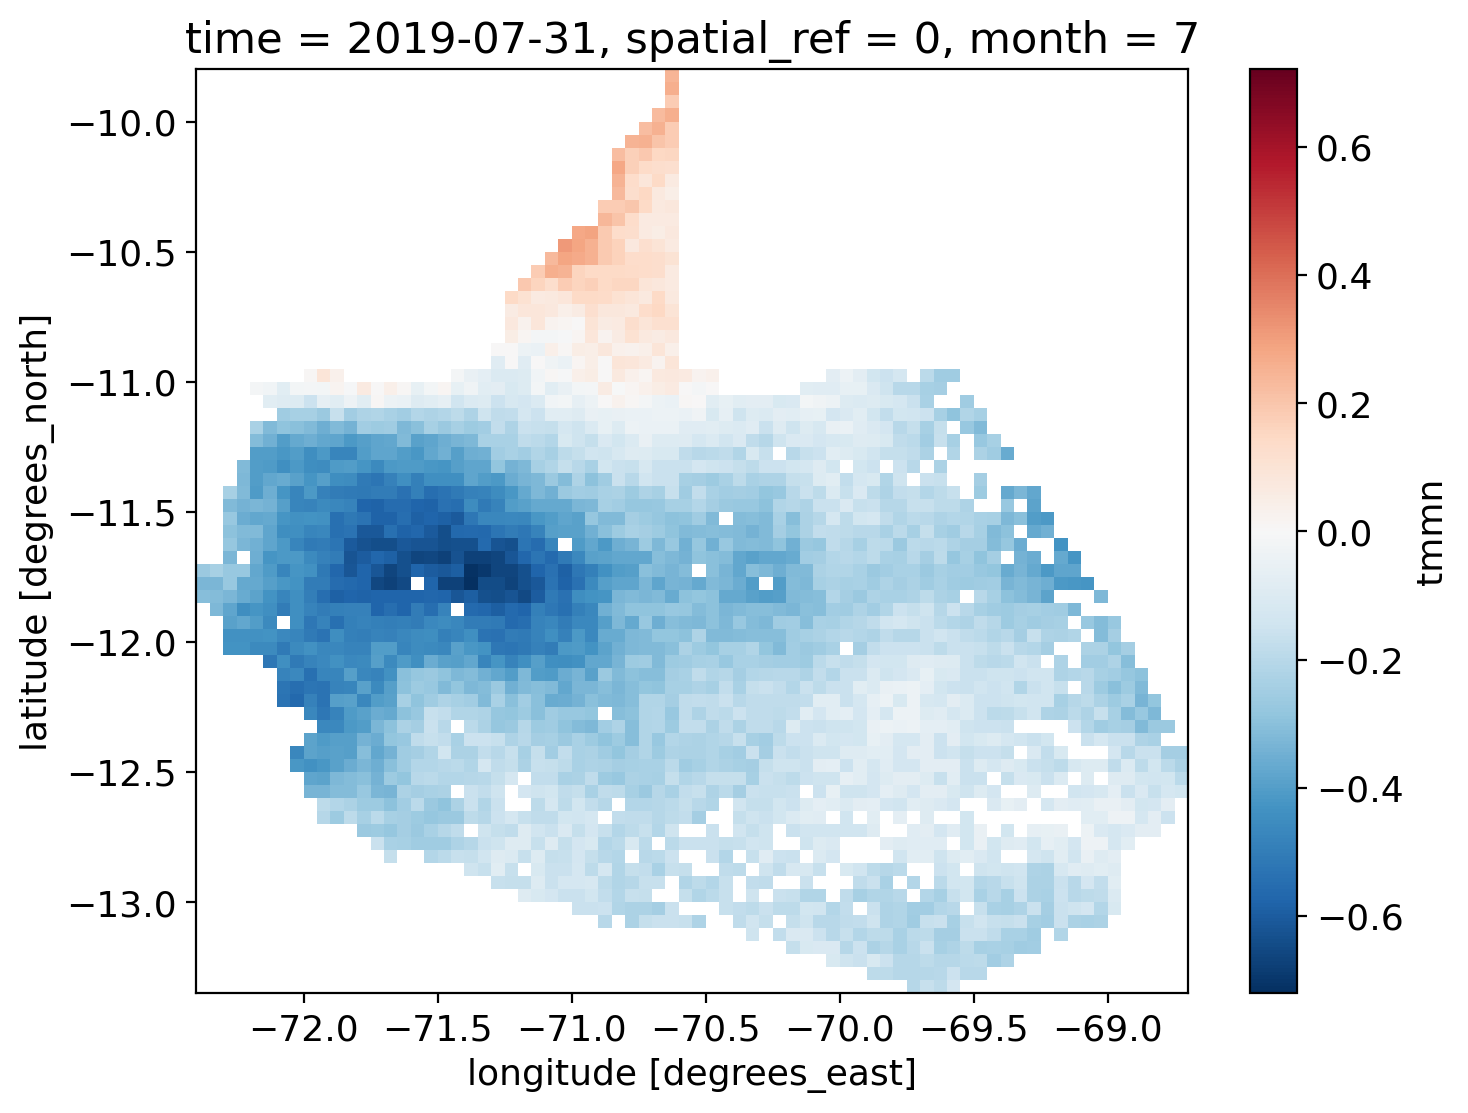

In [4]:
# take a look and map at the ds_combined dataset, this should only cover the political extent of Madre de Dios
print(ds_combined)
ds_combined.tmmn.isel(time=210).plot(figsize=(8,6))

In [5]:
# the data array has 3 dimensions (time, lat, lon). Stack the coordinate values to go from 3d to 2d.
ds_stacked = ds_combined.stack(stacked=("lat", "lon"))

In [6]:
# convert to data frame for later processing. Time, lat, lon become indexes.
df_combined = ds_stacked.to_dataframe().dropna()
print(df_combined)

                                      tmmx      tmmn          pr      pdsi  \
time       lat        lon                                                    
2002-01-31 -9.825002  -70.625000  0.710526  0.610526  127.473684  6.951053   
           -9.875002  -70.625000  0.663158  0.657895  118.894737  7.005263   
           -9.925001  -70.625000  0.642105  0.626316  114.736842  6.954737   
           -9.975001  -70.674995  0.678947  0.642105  108.000000  6.787368   
                      -70.625000  0.626316  0.621053  110.473684  6.945263   
...                                    ...       ...         ...       ...   
2020-12-31 -13.275002 -69.474998  0.763158  0.589474  104.684211 -2.172632   
           -13.325002 -69.724998  0.784211  0.642105  103.894737 -0.917368   
                      -69.674995  0.800000  0.626316  104.526316 -0.950000   
                      -69.625000  0.763158  0.657895  106.368421 -1.386316   
                      -69.574997  0.800000  0.610526  107.631579

In [7]:
# from dataframe generate the x_df (ONLY climate predictor variables, drop the lai column)
x_df = df_combined.drop(columns=["lai","spatial_ref"])

# look at x_df, make sure it looks ok!
x_df.head()

tmmx      tmmn          pr      pdsi  \
time       lat       lon                                                    
2002-01-31 -9.825002 -70.625000  0.710526  0.610526  127.473684  6.951053   
           -9.875002 -70.625000  0.663158  0.657895  118.894737  7.005263   
           -9.925001 -70.625000  0.642105  0.626316  114.736842  6.954737   
           -9.975001 -70.674995  0.678947  0.642105  108.000000  6.787368   
                     -70.625000  0.626316  0.621053  110.473684  6.945263   

                                 def       vpd          soil  month  
time       lat       lon                                             
2002-01-31 -9.825002 -70.625000  0.0  0.092632  5.684342e-14      1  
           -9.875002 -70.625000  0.0  0.092632 -5.684342e-14      1  
           -9.925001 -70.625000  0.0  0.090526  0.000000e+00      1  
           -9.975001 -70.674995  0.0  0.099474 -5.684342e-14      1  
                     -70.625000  0.0  0.096842  5.684342e-14      1

In [8]:
# from dataframe generate y_df (ONLY lai)
y_df = df_combined.drop(columns=["spatial_ref",
                                 "tmmx",
                                 "tmmn",
                                 "pr",
                                 "pdsi",
                                 "def",
                                 "vpd",
                                 "soil"])

# look at y_df, make sure it looks ok!
y_df.head()

lai  month
time       lat       lon                        
2002-01-31 -9.825002 -70.625000  0.657735      1
           -9.875002 -70.625000  0.193407      1
           -9.925001 -70.625000  0.175278      1
           -9.975001 -70.674995  0.773132      1
                     -70.625000  0.000997      1

## Split our data into training, validation and testing and normalize
Look at the entire time sequence of our data: 19 years, 12 months per year
(19yrs x 12months) = 228 time steps

We want the last two years to be our testing dataset: 2019 and 2020
Therefore, the first 17 tears are our training and validation data
Of this, 80% must be training (14 years), 20% must be validation (3 years)

So the final break-down is:
Training: 2002-2015 (14yrs x 12months = 168 ts)
Validation: 2016-2018 (3yrs x 12months = 36 ts)
Testing: 2019-2020 (2yrs x 12months = 24 ts)

In [9]:
# CHANGED

# # 1 - set hyperparameters
# n_neuron       = 64
# num_layers     = 1
# activation     = 'ReLU'
# num_epochs     = 30
# learning_rate  = 0.00001
# minibatch_size = 64 #CHECK
# model_version  = "6_3"
# lookback       = 9

train_yr_start = 2003
# val_yr_start = 2013
test_yr_start = 2016
test_yr_end = 2020

In [10]:
# look at the entire time sequence of our data
first_time = x_df.index.get_level_values("time")[0]
last_time  = x_df.index.get_level_values("time")[-1]

print('time 0 =', first_time)
print('time last =', last_time)

time 0 = 2002-01-31 00:00:00
time last = 2020-12-31 00:00:00


In [11]:
# splitting the data according to the time splits above

# establish the before and after for the testing set
#times = x_df.index.get_level_values("time")
#mask_before_testing = times < '2014-01-31 00:00:00' # everything before 2014 is training-val
#mask_after_testing  = times >= '2014-01-31 00:00:00' # everything after 2014 is testing

# split the data into training + validation and testing
#x_df_train = x_df.loc[mask_before_testing]
#x_df_test_all = x_df.loc[mask_after_testing]
#y_df_train = y_df.loc[mask_before_testing]
#y_df_test_all = y_df.loc[mask_after_testing]

# in the testing data, limit to only 2014 data
#times_testing = x_df_test_all.index.get_level_values("time")
#mask_before_2015 = times_testing < '2015-01-31 00:00:00' # everything before 2015 that has not been assigned to train is testing

#x_df_test = x_df_test_all.loc[mask_before_2015]
#y_df_test = y_df_test_all.loc[mask_before_2015]

# split the training and validation data
#mask_before_train = times < '2012-01-31 00:00:00'
#mask_after_train = times >= '2012-01-31 00:00:00'

# split train into training and validation data
#x_df_train_02 = x_df.loc[mask_before_train]
#x_df_valid_all = x_df.loc[mask_after_train]
#y_df_train_02 = y_df.loc[mask_before_train]
#y_df_valid_all = y_df.loc[mask_after_train]

# in the training data, get rid of 2002 <-- 2002 is an odd year, data wise, introducing a lot of noise
#times_training = x_df_train_02.index.get_level_values("time")
#mask_after_2002 = times_training >= '2003-01-31 00:00:00'

# in the validation data, get rid of everything post 2014
#times_valid = x_df_valid_all.index.get_level_values("time")
#mask_before_2014 = times_valid < '2015-01-31 00:00:00'

#x_df_train = x_df_train_02.loc[mask_after_2002]
#y_df_train = y_df_train_02.loc[mask_after_2002]

#x_df_valid = x_df_valid_all.loc[mask_before_2014]
#y_df_valid = y_df_valid_all.loc[mask_before_2014]

In [12]:
# splitting data into training/validation and testing

# establish the before and after for the testing set
times = x_df.index.get_level_values("time")
mask_before_testing = times < f'{test_yr_start}-01-31 00:00:00' # everything before 2014 is training-val
mask_after_testing  = times >= f'{test_yr_start}-01-31 00:00:00' # everything after 2014 is testing

# split the data into training + validation and testing
x_df_train = x_df.loc[mask_before_testing]
x_df_test_all = x_df.loc[mask_after_testing]
y_df_train = y_df.loc[mask_before_testing]
y_df_test_all = y_df.loc[mask_after_testing]

# in the testing data, limit to only 2014 data
times_testing = x_df_test_all.index.get_level_values("time")
print(times_testing)
mask_before_2015 = times_testing < f'{test_yr_end+1}-01-31 00:00:00' # everything before 2015 that has not been assigned to train is testing

x_df_test = x_df_test_all.loc[mask_before_2015]
y_df_test = y_df_test_all.loc[mask_before_2015]

first_time_test = x_df_test.index.get_level_values("time")[0]
last_time_test  = y_df_test.index.get_level_values("time")[-1]
print('time 0 of testing =', first_time_test)
print('time last of testing =', last_time_test)

DatetimeIndex(['2016-01-31', '2016-01-31', '2016-01-31', '2016-01-31',
               '2016-01-31', '2016-01-31', '2016-01-31', '2016-01-31',
               '2016-01-31', '2016-01-31',
               ...
               '2020-12-31', '2020-12-31', '2020-12-31', '2020-12-31',
               '2020-12-31', '2020-12-31', '2020-12-31', '2020-12-31',
               '2020-12-31', '2020-12-31'],
              dtype='datetime64[ns]', name='time', length=157860, freq=None)
time 0 of testing = 2016-01-31 00:00:00
time last of testing = 2020-12-31 00:00:00


In [13]:
# standardize our training/validation and testing data
# get mean and std values from the training data
mean, std = x_df_train.mean(), x_df_train.std()

# normalize
x_df_train = (x_df_train - mean)/std
x_df_test = (x_df_test - mean)/std

# print(x_df_train)
print(x_df_test)

                                      tmmx      tmmn        pr      pdsi  \
time       lat        lon                                                  
2016-01-31 -9.825002  -70.625000  1.166259  1.432414 -0.026854 -1.035371   
           -9.875002  -70.625000  1.424261  1.671316 -0.043325 -1.047379   
           -9.925001  -70.625000  1.557711  1.782235 -0.044972 -1.064332   
           -9.975001  -70.674995  1.619987  1.645720 -0.052658 -1.043318   
                      -70.625000  1.700056  1.773703 -0.058148 -1.057445   
...                                    ...       ...       ...       ...   
2020-12-31 -13.275002 -69.474998  1.593297  1.074062  1.101907 -0.717863   
           -13.325002 -69.724998  1.628883  1.159384  1.093672 -0.296697   
                      -69.674995  1.655573  1.133787  1.100260 -0.307645   
                      -69.625000  1.593297  1.184981  1.119475 -0.454038   
                      -69.574997  1.655573  1.108191  1.132651 -0.492005   

           

In [14]:
feature_cols = ["tmmx","tmmn","pr","pdsi","def","vpd","soil"]

# let's check the normalizaton
# look at some summary statistics to check the normalization
train_stats = x_df_train[feature_cols].agg(['mean','std']).T
test_stats = x_df_test[feature_cols].agg(['mean','std']).T

# let's check our standardization
print("Training data\n", train_stats)
print("Testing data\n", test_stats)

Training data
               mean  std
tmmx  4.938343e-17  1.0
tmmn -3.292229e-17  1.0
pr    2.469172e-17  1.0
pdsi -4.938343e-17  1.0
def   1.646114e-17  1.0
vpd   6.584458e-17  1.0
soil -8.230572e-18  1.0
Testing data
           mean       std
tmmx  1.152493  1.249618
tmmn  0.450129  1.198679
pr    0.037731  0.704011
pdsi  0.042176  0.618006
def  -0.157532  0.798479
vpd   1.110200  3.067391
soil  0.129739  0.972908


In [15]:
# split the training and validation data, now that it has been normalized

# # split the training and validation data
# times_train = x_df_train.index.get_level_values("time")
# print(times_train)
# mask_before_train = times_train < f'{test_yr_start-1}-01-31 00:00:00'
# mask_after_train = times_train >= f'{test_yr_start-1}-01-31 00:00:00'

# # # split train into training and validation data
# x_df_train = x_df_train.loc[mask_before_train]
# # x_df_valid_all = x_df_train.loc[mask_after_train]
# y_df_train = x_df_train.loc[mask_before_train]
# # y_df_valid_all = y_df_train.loc[mask_after_train]

# in the training data, get rid of 2002 <-- 2002 is an odd year, data wise, introducing a lot of noise
times_training = x_df_train.index.get_level_values("time")
mask_after_2002 = times_training >= f'{train_yr_start}-01-31 00:00:00'

# in the validation data, get rid of everything post 2014
# times_valid = x_df_valid.index.get_level_values("time")
# mask_before_2014 = times_valid < '2015-01-31 00:00:00'

x_df_train = x_df_train.loc[mask_after_2002]
y_df_train = y_df_train.loc[mask_after_2002]

# x_df_valid = x_df_valid.loc[mask_before_2014]
# y_df_valid = y_df_valid.loc[mask_before_2014]

In [16]:
# check the data splits
# look at the entire time sequence of our data
first_time_train = x_df_train.index.get_level_values("time")[0]
last_time_train  = x_df_train.index.get_level_values("time")[-1]

print('time 0 of training =', first_time_train)
print('time last of training =', last_time_train)

# first_time_valid = x_df_valid.index.get_level_values("time")[0]
# last_time_valid  = x_df_valid.index.get_level_values("time")[-1]

time 0 of training = 2003-01-31 00:00:00
time last of training = 2015-12-31 00:00:00


In [17]:
# test to make sure the splits worked:
print('shape x_df_train', x_df_train.shape)
# print('shape x_df_valid', x_df_valid.shape)
print('shape x_df_test', x_df_test_all.shape)

print('shape y_df_train', y_df_train.shape)
# print('shape y_df_valid', y_df_valid.shape)
print('shape y_df_test', y_df_test_all.shape)

shape x_df_train (410436, 8)
shape x_df_test (157860, 8)
shape y_df_train (410436, 2)
shape y_df_test (157860, 2)


In [18]:
# look at some summary statistics to check the normalization
train_stats = x_df_train[feature_cols].agg(['mean','std']).T
# valid_stats = x_df_valid[feature_cols].agg(['mean','std']).T
test_stats = x_df_test[feature_cols].agg(['mean','std']).T

# let's check our standardization
print("Training data\n", train_stats)
# print("Validation data\n", valid_stats)
print("Testing data\n", test_stats)

Training data
               mean       std
tmmx  1.164257e-02  1.010041
tmmn  5.873671e-03  1.019664
pr   -4.433971e-02  0.968228
pdsi -1.099067e-01  0.936277
def   2.813911e-07  1.026467
vpd   5.772396e-03  1.013527
soil -4.188121e-03  1.019417
Testing data
           mean       std
tmmx  1.152493  1.249618
tmmn  0.450129  1.198679
pr    0.037731  0.704011
pdsi  0.042176  0.618006
def  -0.157532  0.798479
vpd   1.110200  3.067391
soil  0.129739  0.972908


In [19]:
print(x_df_train)
print(x_df_test)
print(y_df_train)
print(y_df_test)

                                      tmmx      tmmn        pr      pdsi  \
time       lat        lon                                                  
2003-01-31 -9.825002  -70.625000  1.335295  0.946079  0.797207  1.531359   
           -9.875002  -70.625000  1.086190  0.860757  0.822461  1.596521   
           -9.925001  -70.625000  1.050603  0.809564  0.831246  1.596344   
           -9.975001  -70.674995  1.112880  0.835160  0.802697  1.600582   
                      -70.625000  1.023914  0.638919  0.838932  1.620007   
...                                    ...       ...       ...       ...   
2015-12-31 -13.275002 -69.474998  4.128833 -1.033393 -1.599763  0.738295   
           -13.325002 -69.724998  3.995384 -1.110182 -1.660154  0.699799   
                      -69.674995  4.022073 -1.135779 -1.653566  0.705626   
                      -69.625000  4.128833 -1.084586 -1.634351  0.713573   
                      -69.574997  4.022073 -0.999264 -1.631606  0.722579   

           

In [20]:
def create_lags(df, feature_cols, n_lags):
    """
    df: DataFrame with multi-index (time, lat, lon)
    feature_cols: list of columns to create lags for
    n_lags: number of lag steps
    """
    lagged_dfs = []

    # Group by spatial location
    for (lat, lon), group in df.groupby(level=[1, 2]):
        group_lags = group[feature_cols].copy()
        for col in feature_cols:
            for lag in range(1, n_lags+1):
                group_lags[f"{col}_lag{lag}"] = group[col].shift(lag)
        lagged_dfs.append(group_lags)

    # Concatenate all
    lagged_df = pd.concat(lagged_dfs)
    return lagged_df

In [21]:
# feature_cols = ["tmmx","tmmn","pr","pdsi","def","vpd","soil","month"]
feat = 'tmmx'
train_lags = create_lags(x_df_train, feature_cols = [feat], n_lags=12)
test_lags = create_lags(x_df_test, feature_cols = [feat], n_lags=12)

In [22]:
train_lags_clean = train_lags.dropna()
test_lags_clean = test_lags.dropna()
y_train_lags_clean = y_df_train.loc[train_lags_clean.index]
y_test_lags_clean = y_df_test.loc[test_lags_clean.index]

print(train_lags_clean)
print(len(train_lags_clean))
print(len(y_train_lags_clean))
print(y_test_lags_clean)

test_index = test_lags_clean.index
print(test_index)

                                      tmmx  tmmx_lag1  tmmx_lag2  tmmx_lag3  \
time       lat        lon                                                     
2004-01-31 -13.325002 -69.724998 -0.150440   0.783705   0.783705   0.294391   
2004-02-29 -13.325002 -69.724998  0.570186  -0.150440   0.783705   0.783705   
2004-03-31 -13.325002 -69.724998  1.299709   0.570186  -0.150440   0.783705   
2004-04-30 -13.325002 -69.724998  0.410047   1.299709   0.570186  -0.150440   
2004-05-31 -13.325002 -69.724998  0.160942   0.410047   1.299709   0.570186   
...                                    ...        ...        ...        ...   
2015-08-31 -9.825002  -70.625000  1.762333   0.303288   1.273019   0.801498   
2015-09-30 -9.825002  -70.625000  1.531021   1.762333   0.303288   1.273019   
2015-10-31 -9.825002  -70.625000  1.860196   1.531021   1.762333   0.303288   
2015-11-30 -9.825002  -70.625000  1.646677   1.860196   1.531021   1.762333   
2015-12-31 -9.825002  -70.625000  0.845981   1.64667

In [ ]:
n_estimators      = 100    # Number of trees in random forest
min_samples_split = 10     # Minimum number of samples required to split a node
min_samples_leaf  = 4      # Minimum number of samples required at each leaf node
max_features      = None   # Number of features to consider at every split: 'sqrt', 'log2', or None.
                           # None: max_features=n_feature
max_depth         = 25     # Maximum number of levels in tree
bootstrap         = True   # Method of selecting samples for training each tree

reg0 = RandomForestRegressor(n_estimators=n_estimators,
                             min_samples_split=min_samples_split,
                             min_samples_leaf=min_samples_leaf,
                             max_features=max_features,
                             max_depth=max_depth,
                             bootstrap=bootstrap)

rf_tas = reg0.fit(train_lags_clean,y_train_lags_clean)

In [45]:
# reg0.feature_importances_

importances = pd.Series(
    reg0.feature_importances_,
    index=train_lags_clean.columns
).sort_values(ascending=False)

print(importances)

print('something')

tmmx_lag2     0.109656
tmmx_lag8     0.104987
tmmx_lag7     0.096359
tmmx_lag12    0.094347
tmmx_lag1     0.084118
tmmx_lag3     0.083730
tmmx_lag6     0.079187
tmmx_lag5     0.070198
tmmx_lag4     0.063589
tmmx          0.062778
tmmx_lag11    0.058088
tmmx_lag9     0.055883
tmmx_lag10    0.037081
dtype: float64
something


In [ ]:
# y_test_pre = rf_tas.predict(X_test)
# y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)

# y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
#                                'latitude': X_test_xr.latitude.values, 
#                                'longitude': X_test_xr.longitude.values},
#                         data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

In [51]:
y_pred_test = reg0.predict(test_lags_clean)
y_pred_test

array([[-0.04948563,  9.65478571],
       [ 0.10012615,  7.39924   ],
       [ 0.17313467, 10.15071429],
       ...,
       [-0.36331662,  3.63917857],
       [-0.10891515,  6.4333183 ],
       [-0.4181173 ,  4.00607265]], shape=(126288, 2))

In [49]:
rmse = np.sqrt(mean_squared_error(y_test_lags_clean, y_pred_test))
r2   = r2_score(y_test_lags_clean, y_pred_test)

print("RMSE:", rmse)
print("R²:", r2)

RMSE: 2.5712334438782998
R²: -0.2043821009345047


In [52]:
pred_df = pd.DataFrame({
    "time": test_index.get_level_values("time"),
    "lat":  test_index.get_level_values("lat"),
    "lon":  test_index.get_level_values("lon"),
    "true": y_test_lags_clean.values,
    "pred": y_pred_test
})


# # Choose a pixel (example)
# lat0 = -12.504240199016463
# lon0 = -71.818702040585  

# sw_lat, sw_lon = -12.504240199016463, -71.818702040585     # southwest corner  
# ct_lat, ct_lon = -11.730855612666398, -70.79697352496      # central

# # Extract true and predicted for that pixel
# true_pixel = y_test_lags_clean.xs((lat0, lon0), level=("lat", "lon"))
# pred_pixel = y_pred_test_df.xs((lat0, lon0), level=("lat", "lon"))

# # Plot
# plt.figure(figsize=(12,5))
# plt.plot(true_pixel.index, true_pixel.values, label="True LAI")
# plt.plot(pred_pixel.index, pred_pixel.values, label="Predicted LAI")
# plt.title("True vs Predicted LAI at pixel ({}, {})".format(lat0, lon0))
# plt.xlabel("Time")
# plt.ylabel("LAI")
# plt.legend()
# plt.grid(True)
# plt.show()

KeyError: -12.504240199016463

## Reshape data to feed into the LSTM model
0) Make time a column (not index) in our data
1) Merge predictors and predictands
2) Scale the climate inputs.
   Training data will be normalized to mean=0, std=1, Validation data will be scaled with those meands and std
3) Create the look-back window per pixel!
4) Convert to PyTorch datasets
5) Create the Data Loaders, shuffle=False

In [417]:
# 0 - Ensure Time is a column of our data
# Time is currently an INDEX not a column of our data, we need to convert it into a COLUMN
def ensure_time_column(df):
    if "time" not in df.columns:
        # index must be time
        df = df.reset_index().rename(columns={"index": "time"})
    df["time"] = pd.to_datetime(df["time"])
    return df

In [418]:
# 1 - Merge the X (predictors, climate variables) and Y (predictands, modis lai) datasets
def merge_xy(x_df, y_df):
    x_df = ensure_time_column(x_df)
    y_df = ensure_time_column(y_df)
    
    df = x_df.merge(y_df, on=["time", "lat", "lon"], how="inner")
    df = df.sort_values(["lat", "lon", "time"]).reset_index(drop=True)
    return df

train_df = merge_xy(x_df_train, y_df_train)
valid_df = merge_xy(x_df_valid, y_df_valid)
# adding the test data to this nonsense
test_df = merge_xy(x_df_test, y_df_test)

print(test_df)
print(len(test_df))

            time        lat        lon      tmmx      tmmn        pr  \
0     2015-01-31 -13.325002 -69.724998 -1.338216  0.621308 -0.505745   
1     2015-02-28 -13.325002 -69.724998  0.313514  0.217889  0.643045   
2     2015-03-31 -13.325002 -69.724998 -0.521736  1.248850  0.350356   
3     2015-04-30 -13.325002 -69.724998 -0.212036  0.773711  2.705595   
4     2015-05-31 -13.325002 -69.724998  0.060124  1.544691  1.322325   
...          ...        ...        ...       ...       ...       ...   
94711 2017-08-31  -9.825002 -70.625000  0.144587  1.302639  0.258651   
94712 2017-09-30  -9.825002 -70.625000 -1.882536 -0.033128 -0.198779   
94713 2017-10-31  -9.825002 -70.625000 -2.605168  0.119275 -0.075223   
94714 2017-11-30  -9.825002 -70.625000 -1.225598 -0.302075  0.037349   
94715 2017-12-31  -9.825002 -70.625000  0.069509  0.352362  0.306425   

           pdsi       def       vpd      soil   month_x       lai  month_y  
0     -0.275476 -0.065300 -0.906747  0.066310 -1.593253  0

In [419]:
# 2 - scale the climate inputs
# find the mean and std of each feature in the training dataset and standardize to mean=0, std=1
# then use the mean and std of the TRAINING data to scale the validation data
#feature_cols = ["tmmx", "tmmn", "pr", "pdsi", "def", "vpd", "soil"] # define the feature columns to scale

#scaler = StandardScaler()
#train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols]) # TRAINING DATA, CALL THE FIT_TRANSFORM
#valid_df[feature_cols] = scaler.transform(valid_df[feature_cols]) # VALIDATION DATA, CALL THE TRANSFORM
#test_df[feature_cols] = scaler.transform(test_df[feature_cols]) # TESTING DATA, CALL THE TRANSFORM

# let's check our standardization
#train_stats = train_df[feature_cols].agg(['mean','std']).T
#valid_stats = valid_df[feature_cols].agg(['mean','std']).T
#test_stats = test_df[feature_cols].agg(['mean','std']).T
#print("TRAIN\n", train_stats)
#print("VALID\n", valid_stats)

# TRAINING: Mean of Training data should be very close to 0, and sdt roughly 1
# VALID: Validation data should NOT have the same mean and std values, but it should be scaled to the training data, different values same scale

In [420]:
# 3 - build the lstm sequences for each pixel, establish 3 timesteps (months) as our "look-back" window
# define sequence building function
def build_sequences(df, feature_cols, lookback):
    X_list, y_list, coords, times = [], [], [], []

    # for every lat, lon combination in grouping by lat,lon (pixel)
    for (lat, lon), group in df.groupby(["lat", "lon"]):
        group = group.sort_values("time") #sort by values of time, each time instance is 1 month

        X_vals = group[feature_cols].values #for x, get values of predictors (defined by all feature cols)
        y_vals = group["lai"].values #for y, get values of lai, predictant
        t_vals = group["time"].values

        # for every instance in the length of the entire time sequence minus the lookback window
        for i in range(len(group) - lookback): 
            # the instances in lookback window predict 1 timestep after lookback window, last three months predict the fourth, etc.
            X_list.append(X_vals[i:i+lookback]) # append all the x values in index of instance start to end of instance (length of window)
            y_list.append(y_vals[i+lookback]) # append value that is in place of start of instance + length of lookback window
            coords.append((lat, lon))
            times.append(t_vals[i+lookback])

    return (
        np.array(X_list, dtype=np.float32),
        np.array(y_list, dtype=np.float32),
        coords,
        np.array(times, dtype="datetime64[ns]")
    )

# lookback = 22 # will use the past 6 months (time-steps of data) to get the next 7th month

# apply the function
X_train_np, y_train_np, train_coords, train_times = build_sequences(train_df, feature_cols, lookback)
X_valid_np, y_valid_np, valid_coords, valid_times = build_sequences(valid_df, feature_cols, lookback)
# CHANGED!!!!!!
X_test_np, y_test_np, test_coords, test_times = build_sequences(test_df, feature_cols, lookback)

print("Train X shape:", X_train_np.shape) # (len_t), lookback, feat
print("Valid X shape:", X_valid_np.shape) # (len_v), lookback, feat
print("Test X shape:", X_test_np.shape) # (len_v), lookback, feat
print("Test Y shape:", y_test_np.shape)

print(len(test_times))
print(test_times)


# Train X shape and Valid X shape should have the same lookback and features (the last two values)
# BUT should differ in their first dimension, with Train beging larger reflecting there is a greater ammount of data going into training

Train X shape: (268362, 6, 7)
Valid X shape: (78930, 6, 7)
Test X shape: (78930, 6, 7)
Test Y shape: (78930,)
78930
['2015-07-31T00:00:00.000000000' '2015-08-31T00:00:00.000000000'
 '2015-09-30T00:00:00.000000000' ... '2017-10-31T00:00:00.000000000'
 '2017-11-30T00:00:00.000000000' '2017-12-31T00:00:00.000000000']


In [421]:
# 4 - convert to PYTORCH dataset, ready for model ingestion

# before conversion, check for NaNs again. Model will not work if NaNs are present.
np.isnan(X_valid_np).any(), np.isnan(y_valid_np).any(), np.isnan(X_test_np).any()

# define the pytorch conversion function
class ClimateLAIDataset(Dataset):
    def __init__(self, X, y, coords):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.coords = coords

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ClimateLAIDataset(X_train_np, y_train_np, train_coords)
valid_dataset = ClimateLAIDataset(X_valid_np, y_valid_np, valid_coords)
test_dataset = ClimateLAIDataset(X_test_np, y_test_np, test_coords)

print(test_dataset)

In [422]:
# 5 - DATALOADERS, both should be shuffle=false because this is time series data! we want the chronological order
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, drop_last=False)
val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)
print(test_loader)

## Define LSTM structure
1) set the model hyperparameters
2) define the model
3) define optimizer (ADAM) and evaluation criteria (MSE of loss)

In [423]:
# # CHANGED

# # 1 - set hyperparameters
# n_neuron       = 64
# num_layers     = 1
# activation     = 'ReLU'
# num_epochs     = 30
# learning_rate  = 0.00001
# minibatch_size = 64 #CHECK
# model_num      = 1

In [424]:
# CHANGED

# 2 - define the model

# device definition, make sure model is running on GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model definition
import torch.nn as nn

# class LAI_LSTM(nn.Module):
#     def __init__(self, num_features=7, hidden_size=64, num_layers=1):
#         super(LAI_LSTM, self).__init__()

#         self.lstm = nn.LSTM(
#             input_size=num_features,
#             hidden_size=hidden_size,
#             num_layers=num_layers,
#             batch_first=True
#         )
#         self.fc = nn.Linear(hidden_size, 1)

#     def forward(self, x):

#         # Run LSTM
#         output, (h_n, c_n) = self.lstm(x)
#         # Fully connected layer on last hidden state
#         out = self.fc(h_n[-1])

#         # Squeeze last dimension only
#         out = out.squeeze(1)

#         return out

class InputAttention(nn.Module):
    """
    Feature-level attention (which input variables matter at each timestep)
    """
    def __init__(self, input_dim, hidden_dim):
        super(InputAttention, self).__init__()
        self.attn = nn.Linear(hidden_dim + input_dim, input_dim)

    def forward(self, x_t, h_prev):
        # x_t: [batch, input_dim]
        # h_prev: [batch, hidden_dim]

        combined = torch.cat((x_t, h_prev), dim=1)
        scores = self.attn(combined)                   # [batch, input_dim]
        weights = F.softmax(scores, dim=1)             # feature-level attention
        x_tilde = weights * x_t                        # element-wise weighting

        return x_tilde, weights


class TemporalAttention(nn.Module):
    """
    Time-step attention (which timesteps matter most)
    """
    def __init__(self, hidden_dim):
        super(TemporalAttention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, encoder_outputs):
        # encoder_outputs: [batch, seq_len, hidden_dim]

        scores = self.attn(encoder_outputs)            # [batch, seq_len, 1]
        weights = F.softmax(scores, dim=1)             # time-level attention
        context = torch.sum(weights * encoder_outputs, dim=1)

        return context, weights


class DA_RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=num_layers):
        super(DA_RNN, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM cell for stepwise encoding
        self.encoder_lstm = nn.LSTMCell(input_dim, hidden_dim)

        # Attention blocks
        self.input_attention = InputAttention(input_dim, hidden_dim)
        self.temporal_attention = TemporalAttention(hidden_dim)

        # Output layer
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_dim]
        batch_size, seq_len, input_dim = x.size()

        h_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)
        c_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)

        encoder_outputs = []

        # ----- Encoder with feature-level attention -----
        for t in range(seq_len):
            x_t = x[:, t, :]                                  # [batch, input_dim]

            # Feature-level attention
            x_tilde, feature_weights = self.input_attention(x_t, h_t)

            # LSTM step
            h_t, c_t = self.encoder_lstm(x_tilde, (h_t, c_t))

            encoder_outputs.append(h_t.unsqueeze(1))

        encoder_outputs = torch.cat(encoder_outputs, dim=1)   # [batch, seq_len, hidden_dim]

        # ----- Temporal (time-level) attention -----
        context, time_weights = self.temporal_attention(encoder_outputs)

        # ----- Final prediction -----
        out = self.fc(context)                                # [batch, 1]
        out = out.squeeze(1)

        return out, feature_weights, time_weights

model = DA_RNN(input_dim=len(feature_cols), 
               hidden_dim=n_neuron, 
               num_layers=num_layers)
model.to(device)
print("DA-RNN ready")

DA-RNN ready


In [425]:
# CHANGED

# 3 - define the optimizer (ADAM), and the evaluation criterion: MSELoss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

## Training and saving the model

In [426]:
# CHANGED

from utils import pytorch_train2
train_losses_mse, val_losses_mse = pytorch_train2(model, optimizer, criterion = criterion, 
                                                 device = device, 
                                                 train_loader = train_loader, val_loader = val_loader, 
                                                   num_epochs = num_epochs)

Epoch 1/30, Train Loss: 0.1668, Val Loss: 0.1442
Epoch 2/30, Train Loss: 0.1583, Val Loss: 0.1576
Epoch 3/30, Train Loss: 0.1529, Val Loss: 0.1637
Epoch 4/30, Train Loss: 0.1503, Val Loss: 0.1651
Epoch 5/30, Train Loss: 0.1476, Val Loss: 0.1663
Epoch 6/30, Train Loss: 0.1449, Val Loss: 0.1673
Epoch 7/30, Train Loss: 0.1429, Val Loss: 0.1679
Epoch 8/30, Train Loss: 0.1418, Val Loss: 0.1685
Epoch 9/30, Train Loss: 0.1411, Val Loss: 0.1694
Epoch 10/30, Train Loss: 0.1406, Val Loss: 0.1702
Epoch 11/30, Train Loss: 0.1401, Val Loss: 0.1709
Epoch 12/30, Train Loss: 0.1396, Val Loss: 0.1716
Epoch 13/30, Train Loss: 0.1391, Val Loss: 0.1723
Epoch 14/30, Train Loss: 0.1386, Val Loss: 0.1730
Epoch 15/30, Train Loss: 0.1382, Val Loss: 0.1736
Epoch 16/30, Train Loss: 0.1377, Val Loss: 0.1740
Epoch 17/30, Train Loss: 0.1372, Val Loss: 0.1742
Epoch 18/30, Train Loss: 0.1367, Val Loss: 0.1742
Epoch 19/30, Train Loss: 0.1362, Val Loss: 0.1740
Epoch 20/30, Train Loss: 0.1358, Val Loss: 0.1737
Epoch 21/

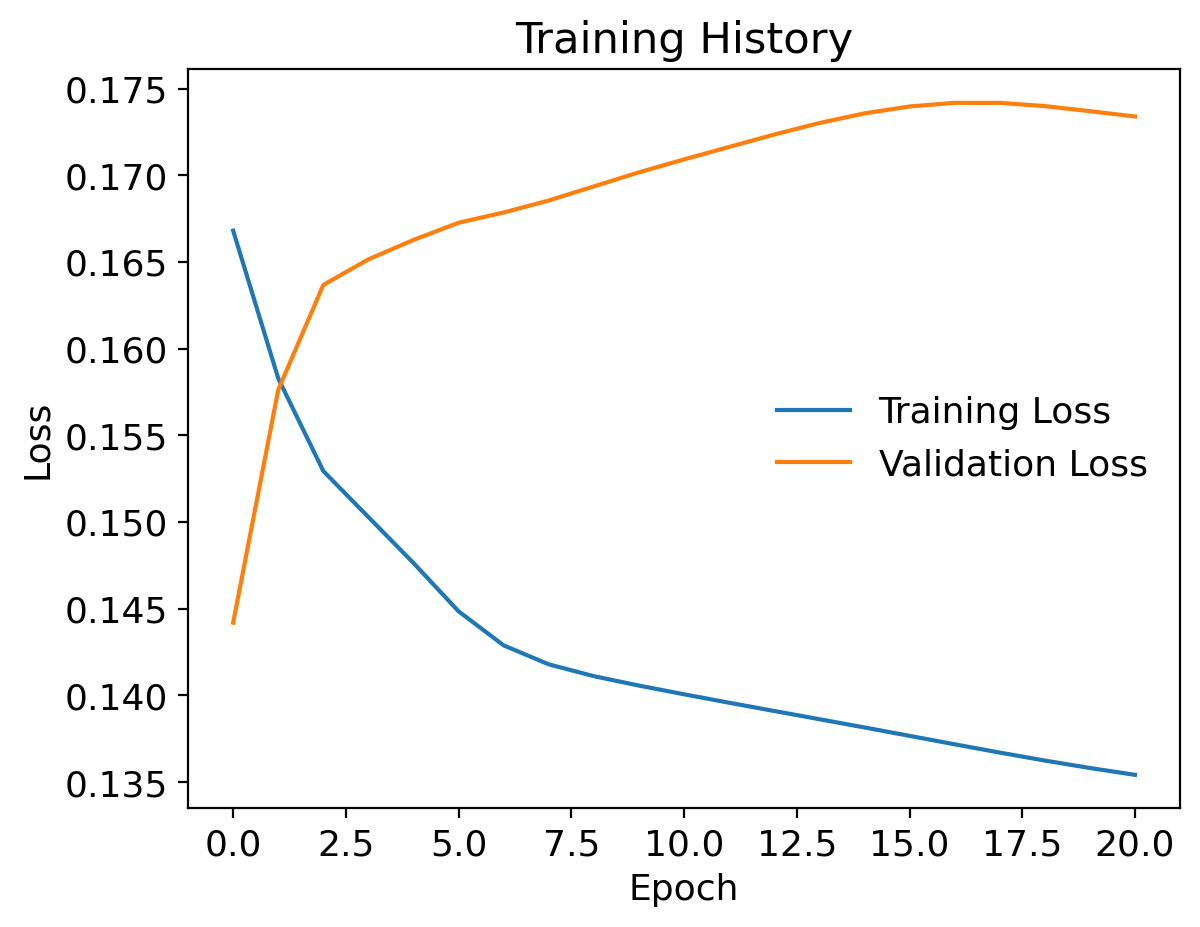

In [427]:
# looking at our training and validation loss
plot_history(train_losses_mse, val_losses_mse)

In [428]:
# # CHANGED

# export and SAVE model
model_path = f"/home/jovyan/large_files/model_outputs/v{model_version}/"
make_dir(model_path)

# Save the model weights to a pth file.
torch.save(model.state_dict(), os.path.join(model_path, f"attn_lkb{lookback}.pth"))

print(model)

DA_RNN(
  (encoder_lstm): LSTMCell(7, 64)
  (input_attention): InputAttention(
    (attn): Linear(in_features=71, out_features=7, bias=True)
  )
  (temporal_attention): TemporalAttention(
    (attn): Linear(in_features=64, out_features=1, bias=True)
  )
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## Variable Importances 

In [429]:
# CHANGED

model.eval()

all_feature_attn = []
all_time_attn = []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(device)

        _, feature_attn, time_attn = model(batch_X)

        all_feature_attn.append(feature_attn.cpu())
        all_time_attn.append(time_attn.cpu())

# Stack and average
all_feature_attn = torch.cat(all_feature_attn, dim=0)
all_time_attn = torch.cat(all_time_attn, dim=0)

var_importance = all_feature_attn.mean(dim=0)
time_importance = all_time_attn.squeeze(-1).mean(dim=0)


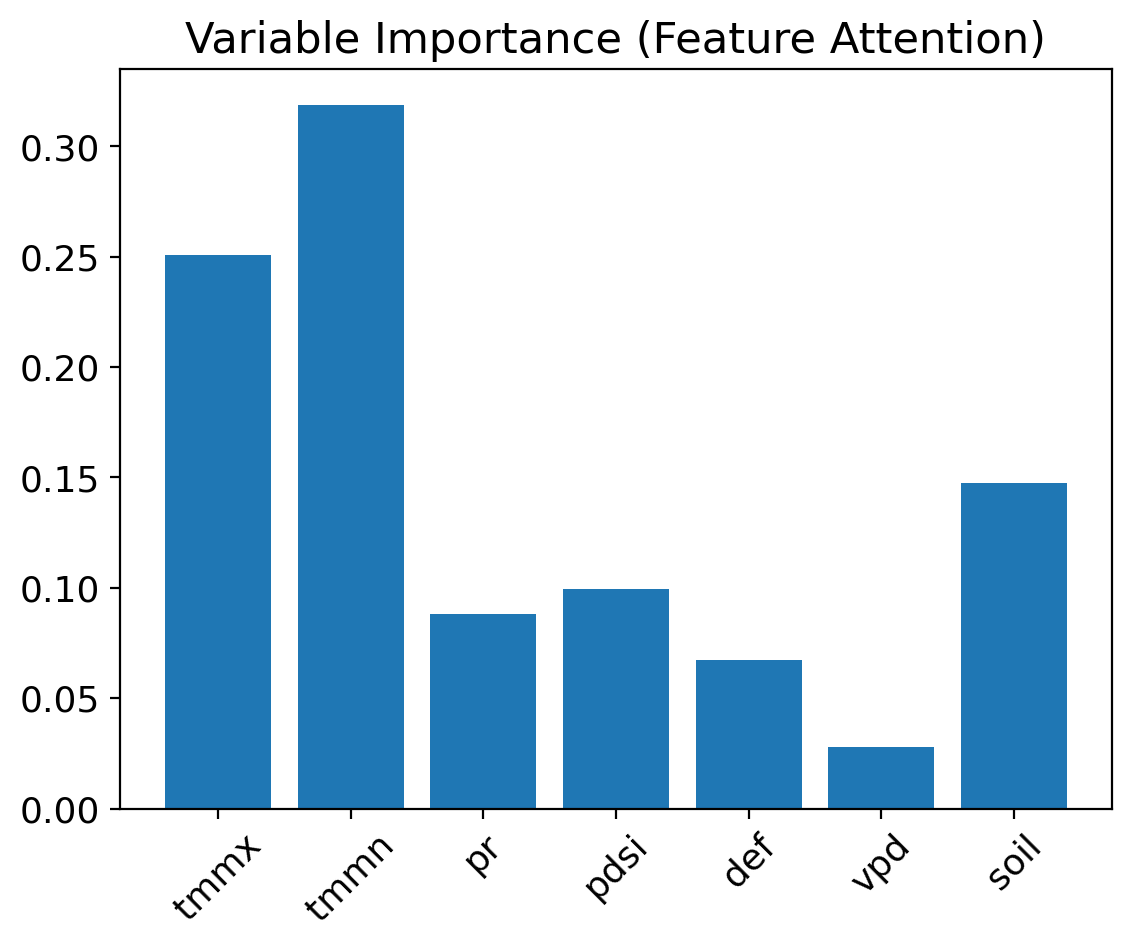

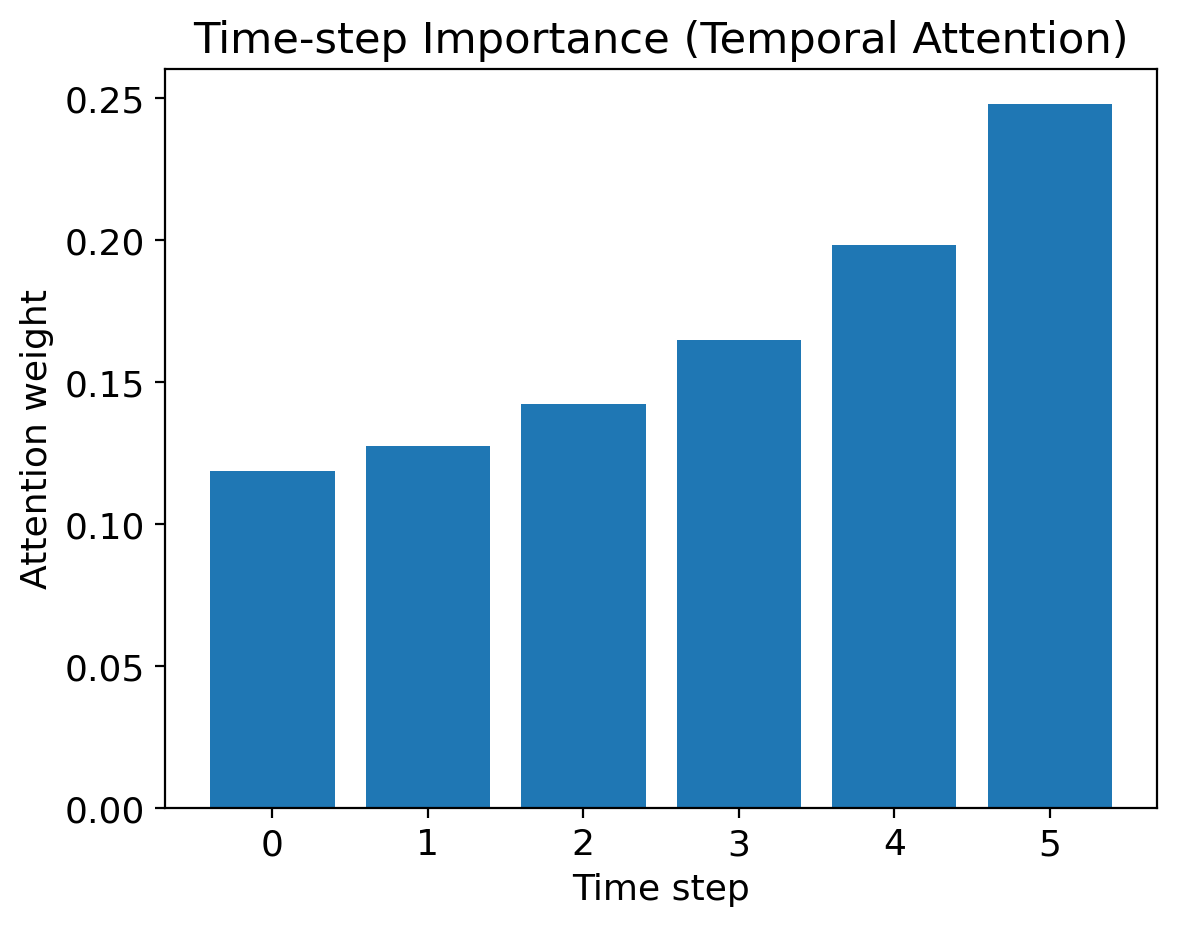

In [430]:
# CHANGED

var_imp_np = var_importance.numpy()
time_imp_np = time_importance.numpy()

# feature_names = ["tmmx","tmmn","pr","pdsi","def","vpd","soil"]

plt.bar(feature_cols, var_imp_np)
plt.xticks(rotation=45)
plt.title("Variable Importance (Feature Attention)")
plt.show()

plt.bar(range(len(time_imp_np)), time_imp_np)
plt.title("Time-step Importance (Temporal Attention)")
plt.xlabel("Time step")
plt.ylabel("Attention weight")
plt.show()

## Testing the Model

In [431]:
# make new model instances
model_eval = DA_RNN(input_dim=len(feature_cols), hidden_dim=n_neuron, num_layers=num_layers)

# reload the saved model weights
state_dict = torch.load(f"/home/jovyan/large_files/model_outputs/v{model_version}/attn_lkb{lookback}.pth", weights_only=True)
model_eval.load_state_dict(state_dict)

<All keys matched successfully>

In [432]:
# run model

model_eval.to(device).eval()
preds_list = []
targs_list = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:   # training loop unchanged
        X_batch = X_batch.to(device)
        outputs, feature_attn, time_attn = model(X_batch)
        preds_list.append(outputs)
        targs_list.append(y_batch.cpu().numpy())

preds = np.concatenate(preds_list, axis=0)
targets = np.concatenate(targs_list, axis=0)

# Get coords from the dataset (must be in same order as samples)
coords = np.array(test_dataset.coords)   # shape (N_samples, 2) or similar

assert len(preds) == len(coords), "Order mismatch: ensure test_loader shuffle=False and drop_last=False"
print('all ok')

print(preds)
print(targets)
print(test_dataset)

all ok
[ 0.09930766  0.14007065  0.21052098 ... -0.07595959 -0.04292738
 -0.01126671]
[-0.6354313  -0.9212314   0.00453131 ...  0.28357434  0.38508072
  0.35424355]


In [433]:
# overall RMSE and MAE
overall_rmse = np.sqrt(np.mean((preds - targets)**2))
print("Overall RMSE:", overall_rmse)

overall_mae = np.mean(np.abs(preds - targets))
print("Overall MAE:", overall_mae)

Overall RMSE: 0.46617433
Overall MAE: 0.3750705


In [434]:
# compute the rmse per pixel and return a df of values INDEXED exactly as the input data
# def compute_rmse_per_pixel(coords, preds, targets):
#     df = pd.DataFrame({
#         "lat": coords[:, 0],
#         "lon": coords[:, 1],
#         "pred": preds,
#         "true": targets
#     })

#     def rmse(x, y):
#         return np.sqrt(np.mean((x - y)**2))

#     rmse_df = df.groupby(["lat", "lon"]).apply(
#         lambda g: rmse(g["pred"], g["true"])
#     ).reset_index(name="rmse")

#     return rmse_df

def compute_error_per_pixel(coords, preds, targets):
    df = pd.DataFrame({
        "lat": coords[:, 0],
        "lon": coords[:, 1],
        "pred": preds,
        "true": targets
    })

    def rmse(x, y):
        return np.sqrt(np.mean((x - y)**2))

    def mae(x, y):
        return np.mean(np.abs(x - y))

    error_df = df.groupby(["lat", "lon"]).apply(
        lambda g: pd.Series({
            "rmse": rmse(g["pred"], g["true"]),
            "mae": mae(g["pred"], g["true"])
        })
    ).reset_index()

    return error_df

In [435]:
# take a look at this!
# rmse_df = compute_rmse_per_pixel(coords, preds, targets)
# print(rmse_df.head())

error_df = compute_error_per_pixel(coords, preds, targets)
print(error_df.head())

         lat        lon      rmse       mae
0 -13.325002 -69.724998  0.495749  0.415285
1 -13.325002 -69.674995  0.458298  0.380033
2 -13.325002 -69.625000  0.381077  0.313295
3 -13.325002 -69.574997  0.605126  0.488103
4 -13.275002 -69.875000  0.451822  0.387563


/tmp/ipykernel_409/813597340.py:33: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  error_df = df.groupby(["lat", "lon"]).apply(


In [436]:
# save the rmse calculations to a raster
# def rmse_to_raster(rmse_df):
#     lats = np.sort(rmse_df["lat"].unique())
#     lons = np.sort(rmse_df["lon"].unique())

#     # Initialize raster
#     raster = np.full((len(lats), len(lons)), np.nan, dtype=float)

#     # Fill raster per coordinate
#     for _, row in rmse_df.iterrows():
#         lat_idx = np.where(lats == row["lat"])[0][0]
#         lon_idx = np.where(lons == row["lon"])[0][0]
#         raster[lat_idx, lon_idx] = row["rmse"]

#     return raster, lats, lons

def metric_to_raster(df, metric):
    lats = np.sort(df["lat"].unique())
    lons = np.sort(df["lon"].unique())

    raster = np.full((len(lats), len(lons)), np.nan, dtype=float)

    for _, row in df.iterrows():
        lat_idx = np.where(lats == row["lat"])[0][0]
        lon_idx = np.where(lons == row["lon"])[0][0]
        raster[lat_idx, lon_idx] = row[metric]

    return raster, lats, lons


In [437]:
# run raster saving function from above
# rmse_raster, lats, lons = rmse_to_raster(rmse_df)
# rmse_raster = np.flipud(rmse_raster)
# lats = lats[::-1]
# print(rmse_raster.shape)

rmse_raster, lats, lons = metric_to_raster(error_df, "rmse")
rmse_raster = np.flipud(rmse_raster)

mae_raster, mae_lats, mae_lons = metric_to_raster(error_df, "mae")
mae_raster = np.flipud(mae_raster)

rmse_lats = lats[::-1]
print(rmse_raster.shape)
print(mae_raster.shape)
# print(rmse_raster)
# print(mae_raster)

(71, 74)
(71, 74)


In [438]:
# save your rmse raster to a geotiff
import rasterio
from rasterio.transform import from_origin

def save_rmse_geotiff(filename, raster, lats, lons):
    # Compute resolution
    lat_res = abs(lats[1] - lats[0])
    lon_res = abs(lons[1] - lons[0])
    
    transform = from_origin(min(lons), max(lats), lon_res, lat_res)

    with rasterio.open(
        filename,
        "w",
        driver="GTiff",
        height=raster.shape[0],
        width=raster.shape[1],
        count=1,
        dtype=raster.dtype,
        crs="EPSG:4326",
        transform=transform,
    ) as dst:
        dst.write(raster, 1)

In [439]:
# run and save! name your save with the length of the looback window
save_rmse_geotiff(f"/home/jovyan/MLEAEEE4000-DroughtAmazon2/figures/RMSE_maps/v{model_version}/attn_lkb{lookback}.tif", rmse_raster, lats, lons)

RasterioIOError: Attempt to create new tiff file '/home/jovyan/MLEAEEE4000-DroughtAmazon2/figures/RMSE_maps/v6_3/attn_lkb6.tif' failed: /home/jovyan/MLEAEEE4000-DroughtAmazon2/figures/RMSE_maps/v6_3/attn_lkb6.tif: No such file or directory

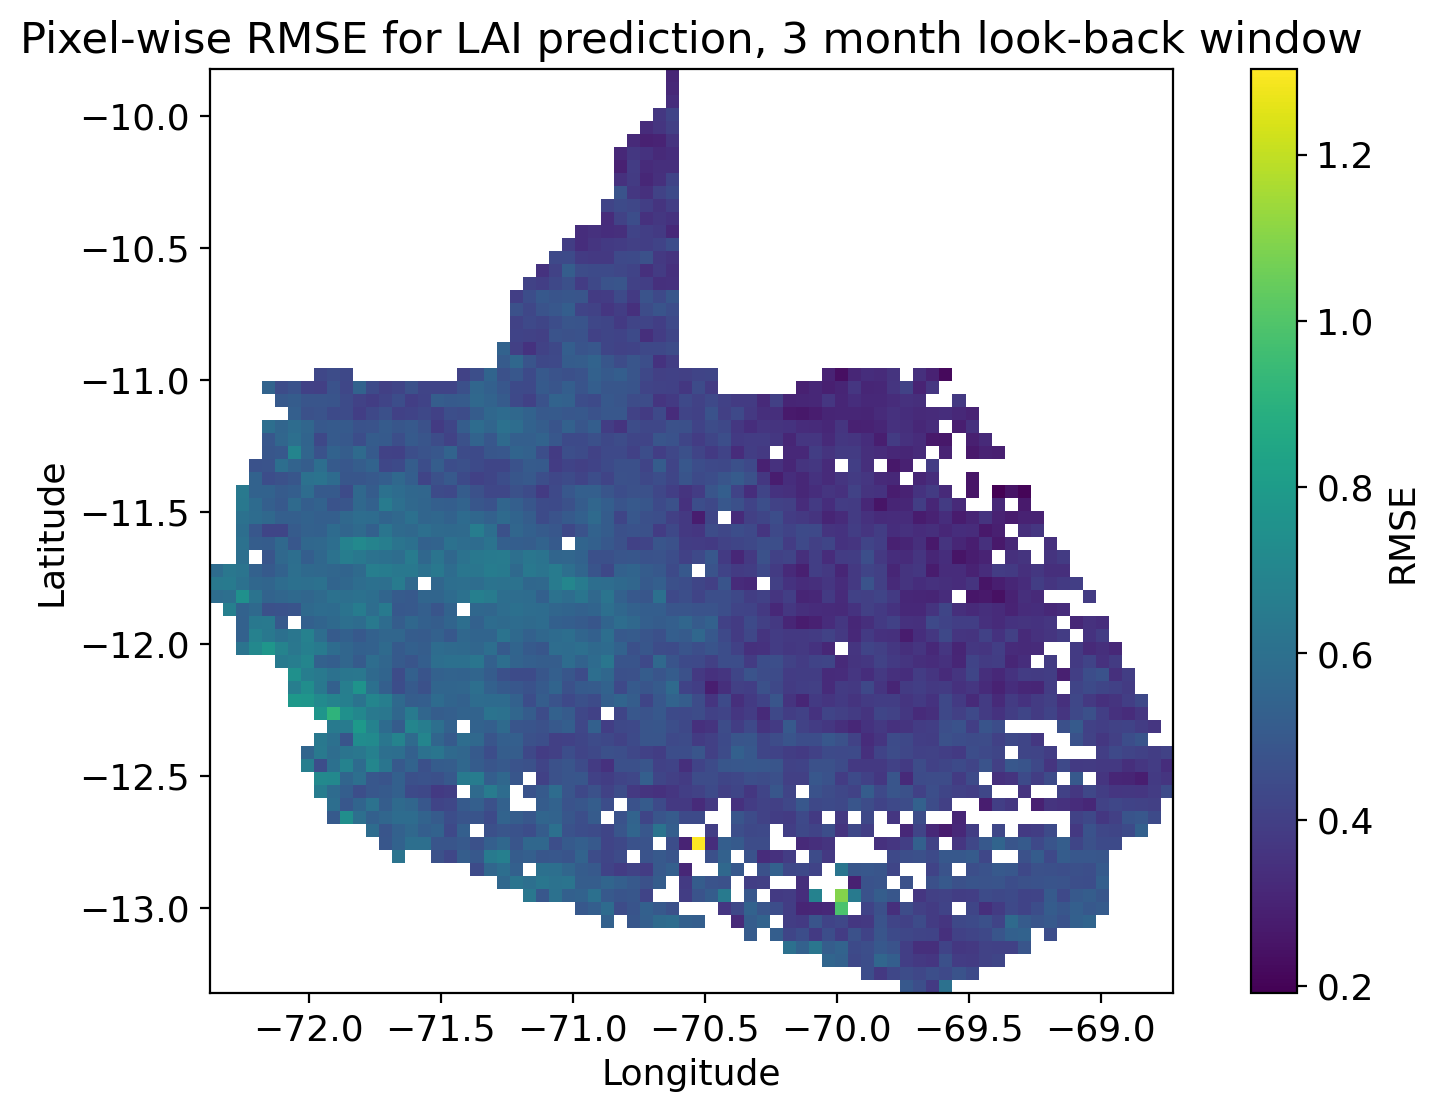

In [440]:
# plot your rmse raster
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.imshow(rmse_raster, cmap="viridis", origin="upper",
           extent=[min(lons), max(lons), min(lats), max(lats)])
plt.colorbar(label="RMSE")
plt.title("Pixel-wise RMSE for LAI prediction, 3 month look-back window")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

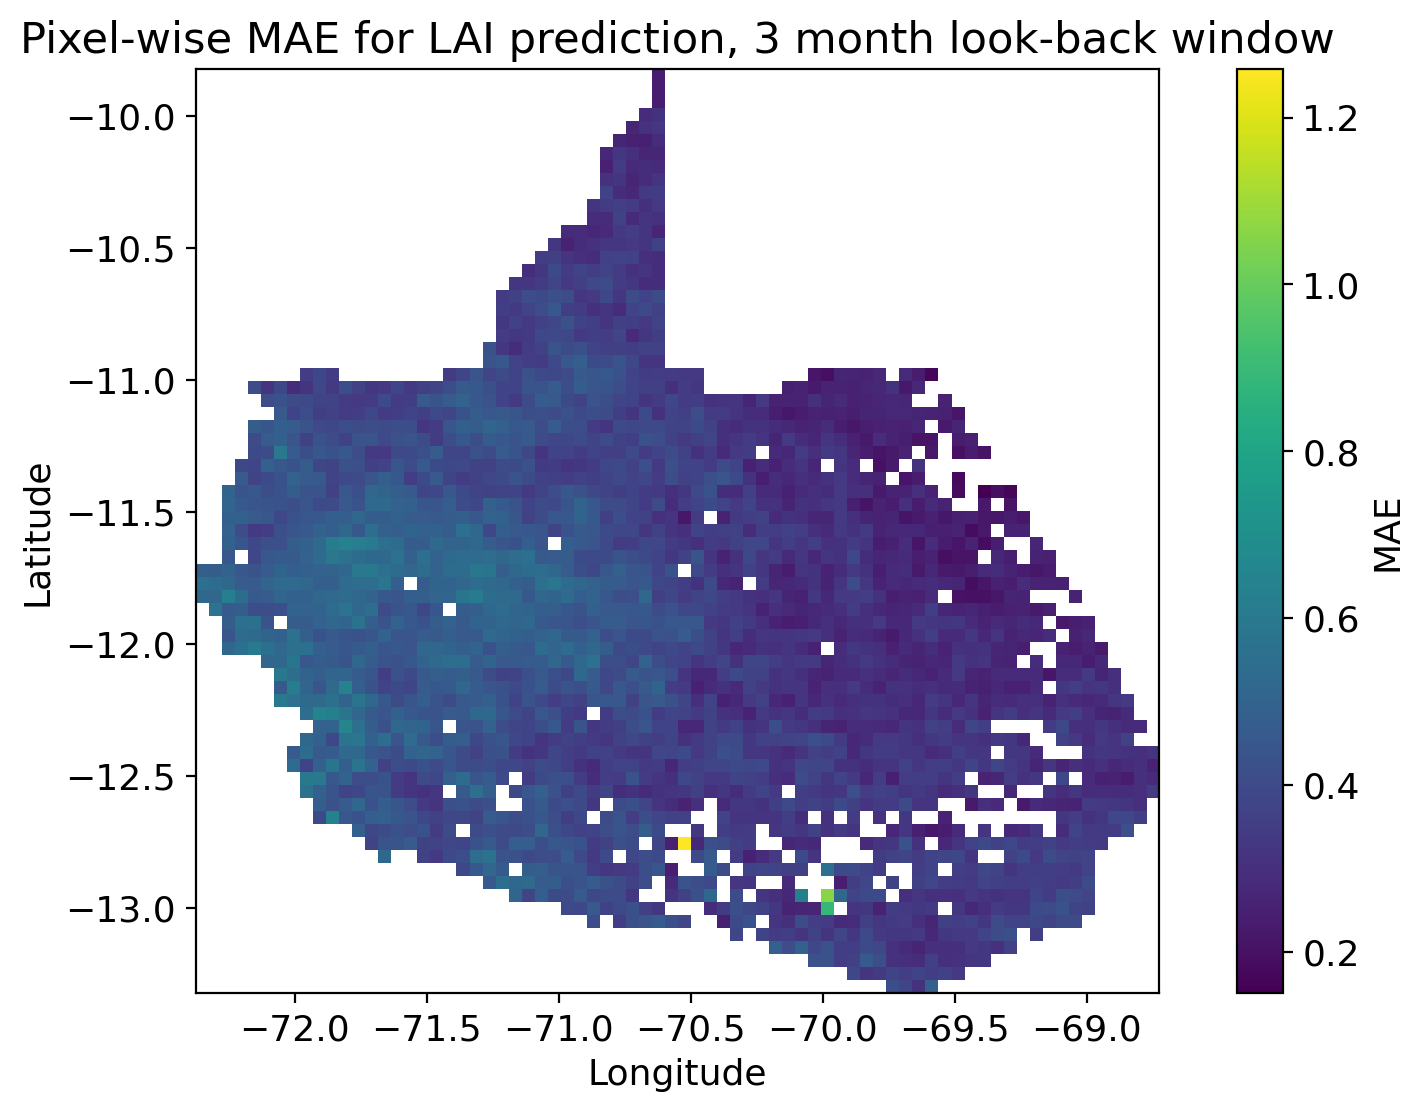

In [441]:
# plot your rmse raster
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.imshow(mae_raster, cmap="viridis", origin="upper",
           extent=[min(lons), max(lons), min(lats), max(lats)])
plt.colorbar(label="MAE")
plt.title("Pixel-wise MAE for LAI prediction, 3 month look-back window")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [442]:
# print(dir(test_dataset))
# print(test_dataset)

# seq_len = test_dataset.X.shape[1]
# N = len(test_dataset)

# N

df = pd.DataFrame({
    "time": test_times,
    "pred": preds.squeeze(),
    "true": targets.squeeze(),
    "lat": coords[:, 0],
    "lon": coords[:, 1]
})

print(df)

print(times_testing)

print(len(preds))
print(len(targets))
print(len(test_times))

print(df[['lat','lon']].head())
print(df[['lat','lon']].describe())

print(df[['lat','lon']].drop_duplicates().shape)
print(df[['lat','lon']].drop_duplicates().head(20))

# df.time.iloc[0], type(df.time.iloc[0])

            time      pred      true        lat        lon
0     2015-07-31  0.099308 -0.635431 -13.325002 -69.724998
1     2015-08-31  0.140071 -0.921231 -13.325002 -69.724998
2     2015-09-30  0.210521  0.004531 -13.325002 -69.724998
3     2015-10-31  0.291327  0.050220 -13.325002 -69.724998
4     2015-11-30  0.244527 -0.006503 -13.325002 -69.724998
...          ...       ...       ...        ...        ...
78925 2017-08-31 -0.035653 -0.043347  -9.825002 -70.625000
78926 2017-09-30 -0.057810  0.028345  -9.825002 -70.625000
78927 2017-10-31 -0.075960  0.283574  -9.825002 -70.625000
78928 2017-11-30 -0.042927  0.385081  -9.825002 -70.625000
78929 2017-12-31 -0.011267  0.354244  -9.825002 -70.625000

[78930 rows x 5 columns]
DatetimeIndex(['2015-01-31', '2015-01-31', '2015-01-31', '2015-01-31',
               '2015-01-31', '2015-01-31', '2015-01-31', '2015-01-31',
               '2015-01-31', '2015-01-31',
               ...
               '2020-12-31', '2020-12-31', '2020-12-31', '2020

Nearest to SW: lat   -12.525002
lon   -71.824997
Name: 16920, dtype: object
Nearest to CT: lat   -11.725001
lon   -70.775002
Name: 48480, dtype: object


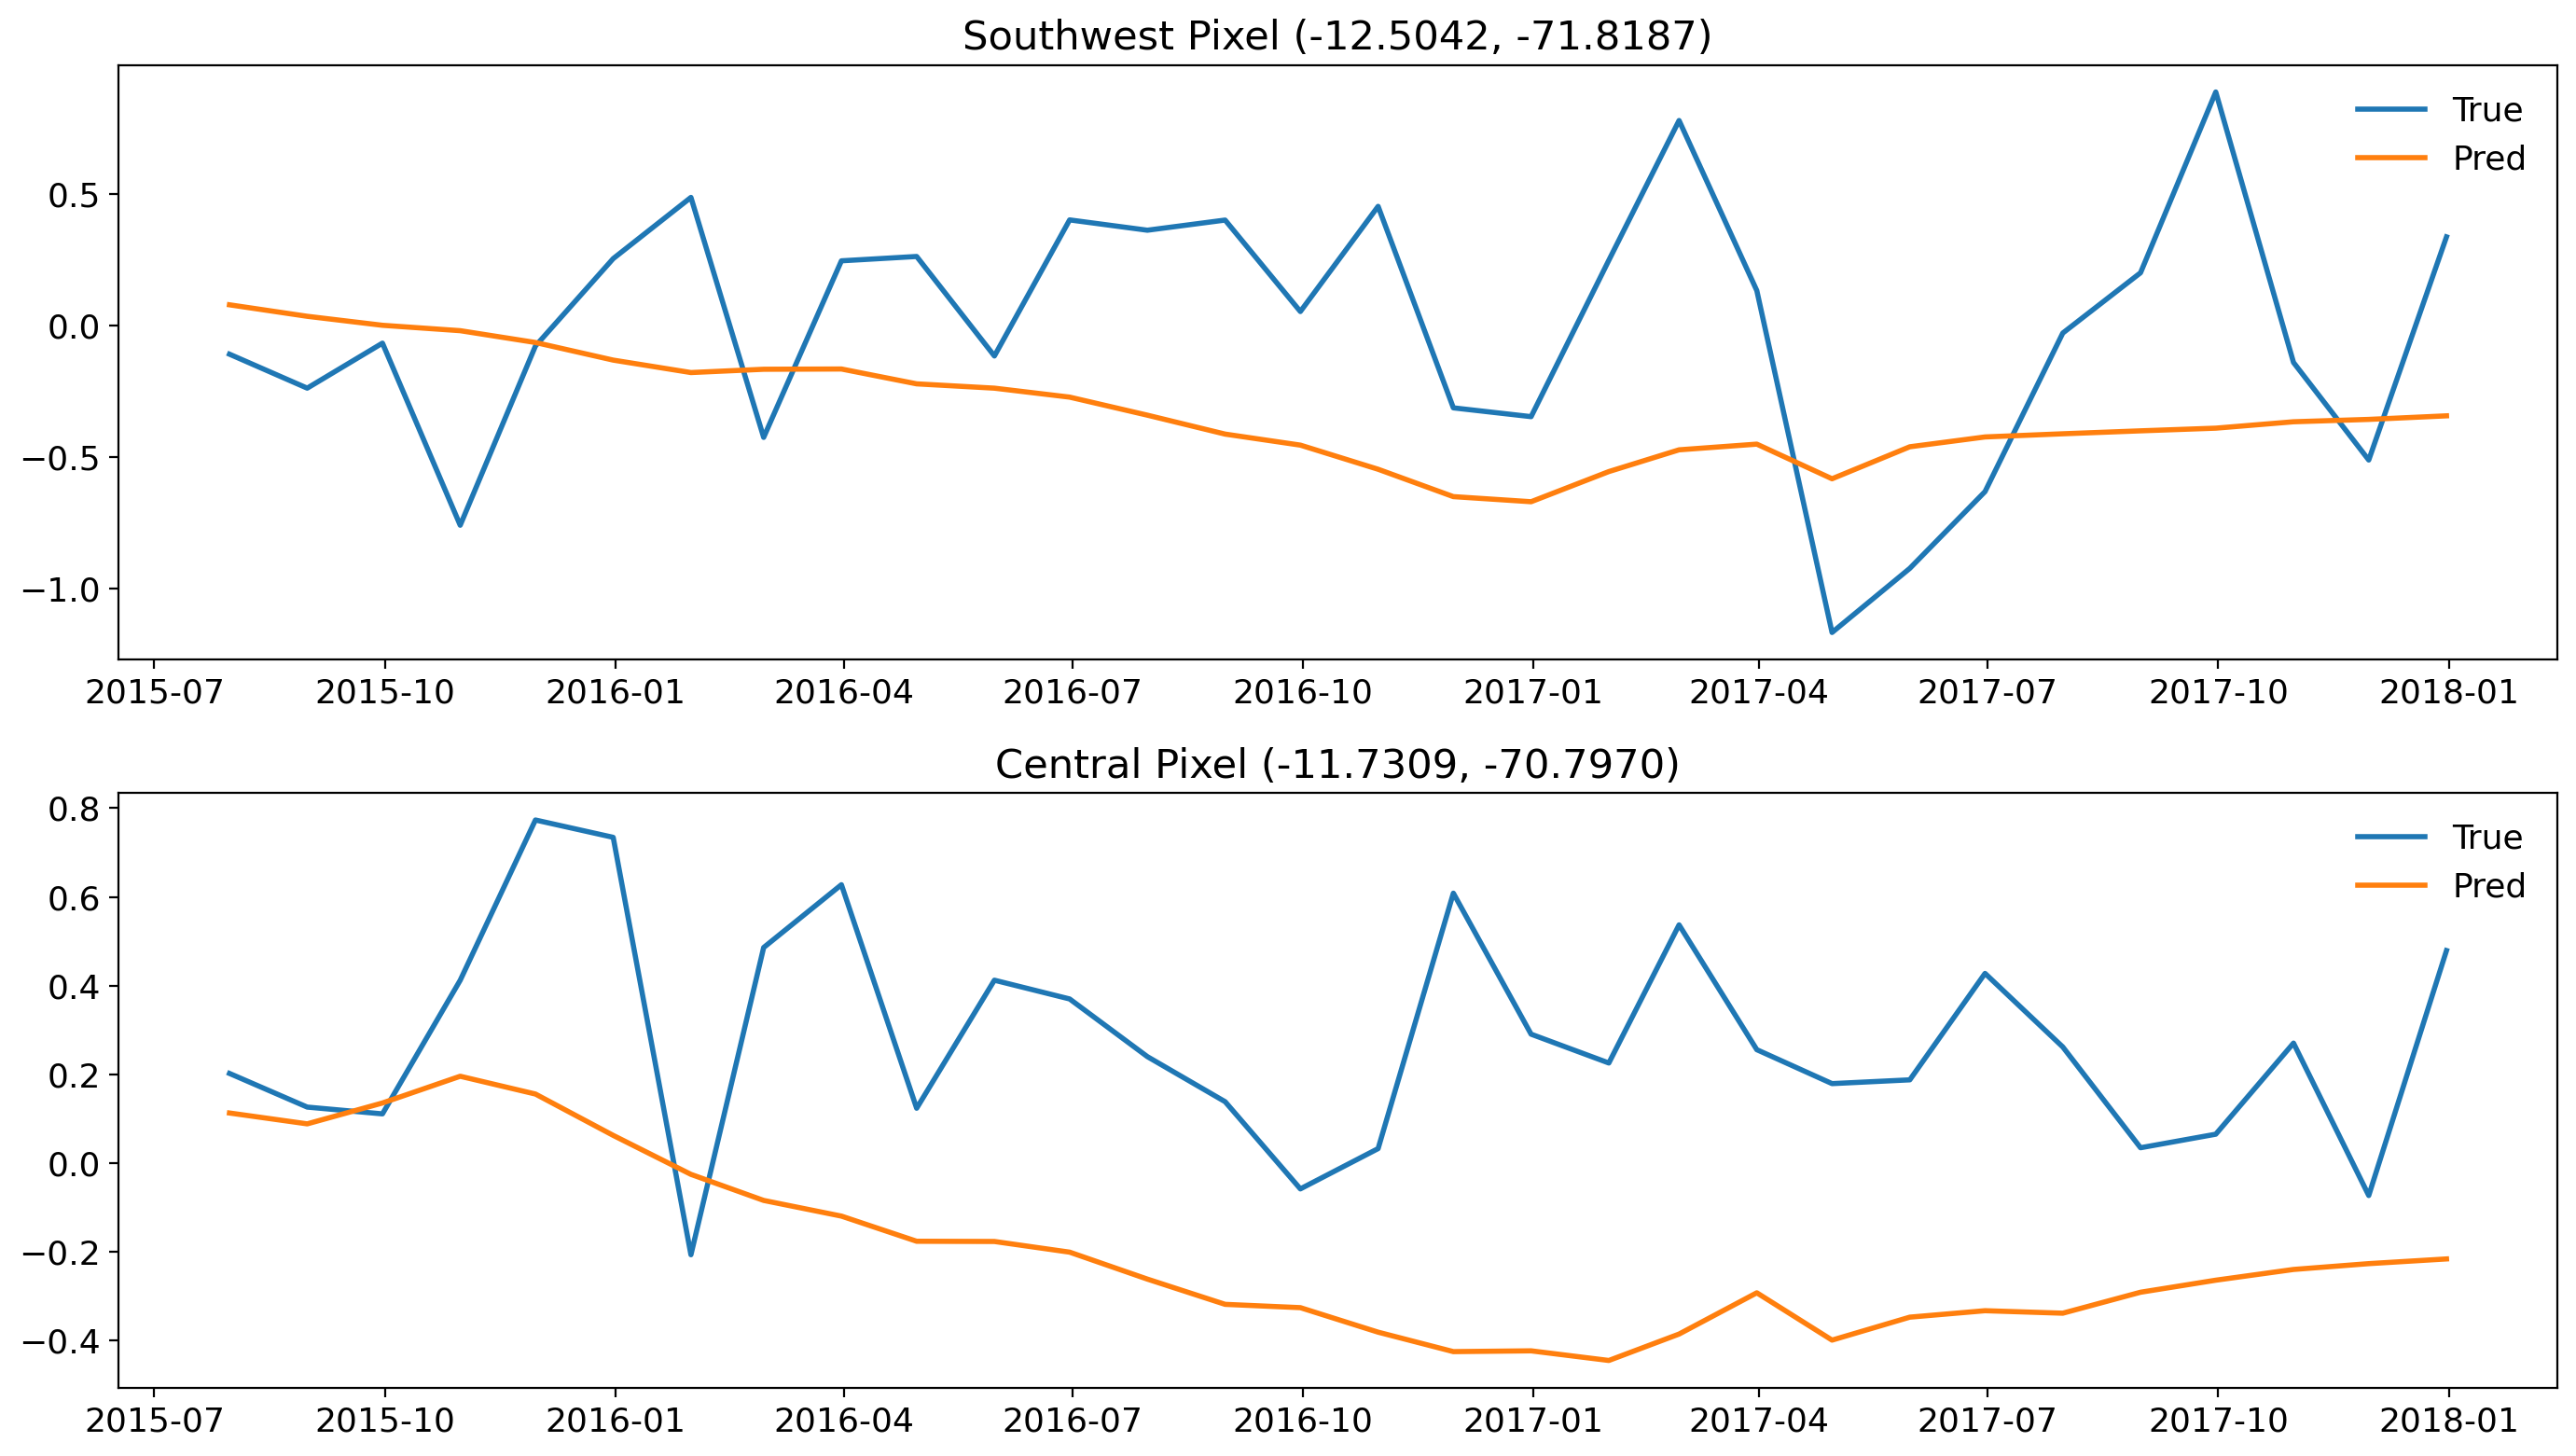

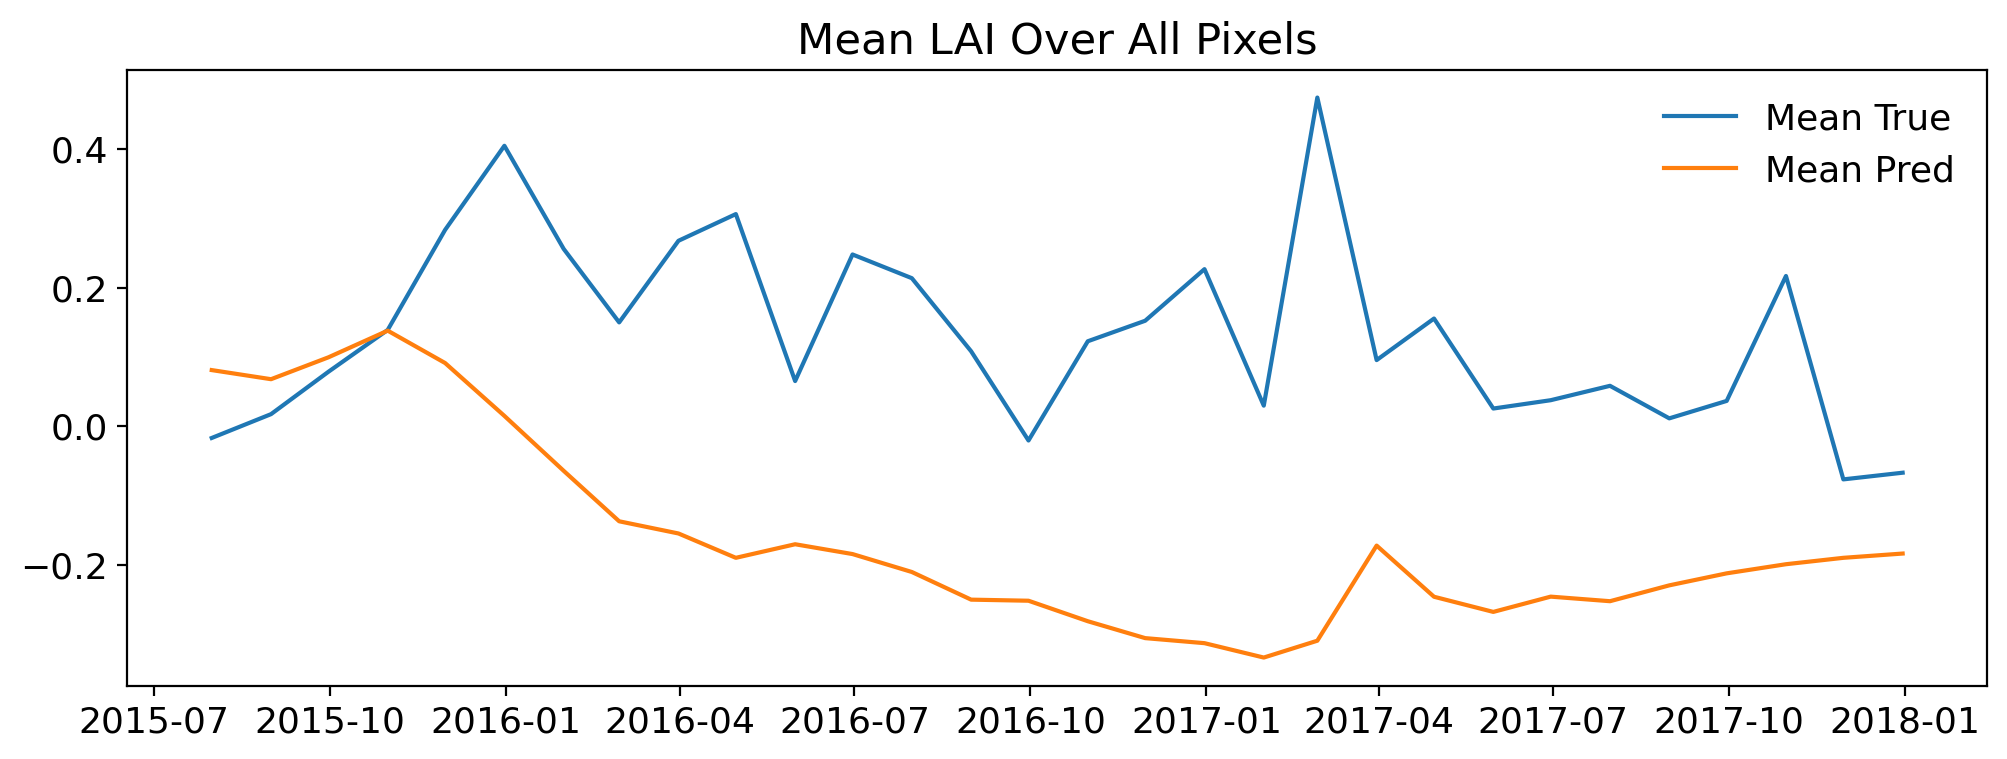

In [443]:
# southwest corner
# Longitude: -71.818702040585
# Latitude: -12.504240199016463

# central
# Longitude: -70.79697352496
# Latitude: -11.730855612666398

# pix = df[(df.lat == df.lat.iloc[0]) & (df.lon == df.lon.iloc[0])]

# --- Define your two points ---
sw_lat, sw_lon = -12.504240199016463, -71.818702040585     # southwest corner  
ct_lat, ct_lon = -11.730855612666398, -70.79697352496      # central

def nearest_pixel(df, target_lat, target_lon):
    d = np.sqrt((df.lat - target_lat)**2 + (df.lon - target_lon)**2)
    idx = d.idxmin()
    return df.loc[idx, ['lat','lon']]

print("Nearest to SW:", nearest_pixel(df, sw_lat, sw_lon))
print("Nearest to CT:", nearest_pixel(df, ct_lat, ct_lon))

# Get nearest actual coords
sw_actual = nearest_pixel(df, sw_lat, sw_lon)
ct_actual = nearest_pixel(df, ct_lat, ct_lon)

pix_sw = df[(df.lat == sw_actual.lat) & (df.lon == sw_actual.lon)]
pix_ct = df[(df.lat == ct_actual.lat) & (df.lon == ct_actual.lon)]

# tol = 1e-5
# pix_sw = df[(abs(df.lat - sw_lat) < tol) & (abs(df.lon - sw_lon) < tol)]
# pix_ct = df[(abs(df.lat - ct_lat) < tol) & (abs(df.lon - ct_lat) < tol)]

# --- Extract data for each pixel ---
# pix_sw = df[(df.lat == sw_lat) & (df.lon == sw_lon)]
# pix_ct = df[(df.lat == ct_lat) & (df.lon == ct_lat)]

# --- Plot both pixels on separate subplots ---
plt.figure(figsize=(14,8))

# Southwest pixel
plt.subplot(2,1,1)
plt.plot(pix_sw.time, pix_sw.true, label="True", linewidth=2)
plt.plot(pix_sw.time, pix_sw.pred, label="Pred", linewidth=2)
plt.title("Southwest Pixel (-12.5042, -71.8187)")
plt.legend()

# Central pixel
plt.subplot(2,1,2)
plt.plot(pix_ct.time, pix_ct.true, label="True", linewidth=2)
plt.plot(pix_ct.time, pix_ct.pred, label="Pred", linewidth=2)
plt.title("Central Pixel (-11.7309, -70.7970)")
plt.legend()

plt.tight_layout()
plt.show()



mean_ts = df.groupby("time")[["pred","true"]].mean()

plt.figure(figsize=(12,4))
plt.plot(mean_ts.index, mean_ts["true"], label="Mean True")
plt.plot(mean_ts.index, mean_ts["pred"], label="Mean Pred")
plt.legend()
plt.title("Mean LAI Over All Pixels")
plt.show()